Rebuilding the Dupuis+ spot model

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
import matplotlib.gridspec as gridspec
import scipy.interpolate as interpolate

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [39]:
def spot(phi, gamma, U =2.784, kw=0.):
    eps0, reg, d = coverage(phi, gamma) 
    c = U*(1-(1-kw)*eps0)
    return c, eps0, reg, d

def coverage(phi, gamma):
    k = np.sin(gamma)
    z0 = get_z0(phi)
    d = ((1-k**2)*(1-z0**2))**0.5 
    if  d <= (1 - k**2) and gamma >=np.pi/2:
        eps = 1.0
        reg= 1
    elif  d <= (1 - k**2):
        reg= 2
        eps = (k**2)*z0
    elif  d > (1 - k**2):
        reg= 3
        s = (1 - k**2)/d 
        v = (d - s) / (k*z0)
        eps = (1/np.pi) *( np.arccos(s) - (s*(1-s**2)**0.5) + ( (k**2) * z0*(np.arccos(v) - (v*(1-v**2)**0.5))))
        
    if eps < 0:
        eps = 0 #hack? I guess? It fixes it?
        
    return eps, reg, d

def get_z0(phi, beta = 43.193*np.pi/180, i =np.pi/2, lam=np.pi):
    z0 = np.cos(lam - phi) * np.cos(beta) * np.sin(i) + np.sin(beta) * np.cos(i)
    return z0



2.784
2.0982292833105083


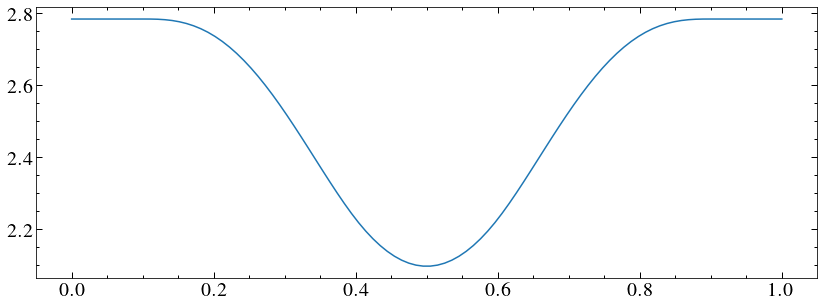

In [40]:
phi = np.linspace(0, 360, 100)
#ds = [np.tan((1-p)*np.pi) for p in phi]
gamma = 35.55*np.pi/180
counts = np.array([spot(p*np.pi/180, gamma) for p in phi])
plt.plot(phi/360, counts[:,0])
#plt.plot(phi, counts[:,1])
#plt.plot(phi, counts[:,2])
#plt.plot(phi, counts[:,3])
#plt.axhline(2.78)
#plt.axvline(90)
#plt.axvline(270)
print(max(counts[:,0]))
print(min(counts[:,0]))

In [41]:
savdat = Table([phi/360, counts[:,0]],names=['PHASE', 'COUNTS'])
ascii.write(savdat, 'spot_model.ecsv', format='ecsv', overwrite=True)

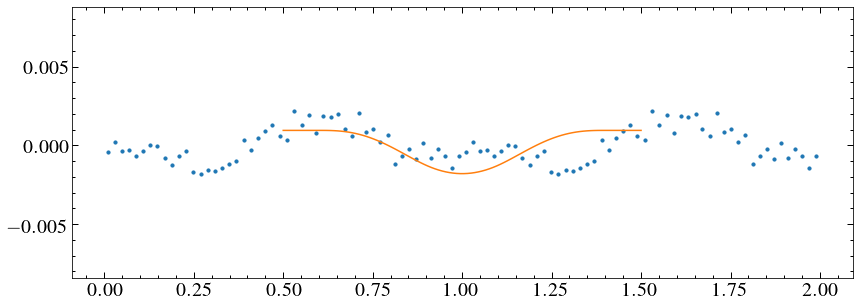

In [42]:
data = fits.getdata('folded_joint_lc.fits', 1)
t, f, e = data['TIME'], data['FLUX'], data['FLUX_ERR']
lc_fold = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)

pbin =int(len(lc_fold.time)/50)

#plt.ylim(-0.009, 0.009)
plt.scatter(lc_fold.bin(pbin).time+0.5, lc_fold.bin(pbin).flux, s=10, c='C0')
plt.scatter(lc_fold.bin(pbin).time+1.5, lc_fold.bin(pbin).flux, s=10, c='C0')

fl = lc_fold.bin(pbin).flux
phase, mod = phi/360, counts[:,0]
#scale = (max(mod)/min(mod)) * abs((max(fl)/min(fl)))
plt.plot(phase+0.5, (mod-np.mean(mod))/250, c='C1')

In [43]:
25/0.1

250.0

Compare with actual EUVE data?

In [44]:
et, ef, ee = np.loadtxt('euve_lc/ds_5760_ltc_obs2.ascii', unpack=True)

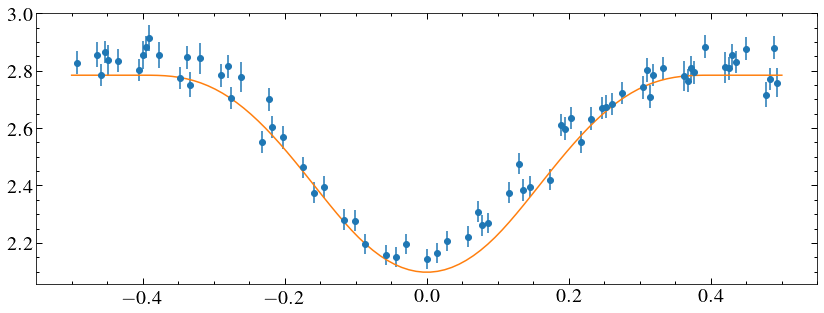

In [45]:
euve_lc = lk.LightCurve(time=et/86400, flux=ef, flux_err=ee)
#plt.errorbar(euve_lc.time, euve_lc.flux, yerr=euve_lc.flux_err, marker='o', ls='none')
t0 = euve_lc.time[np.where(ef == np.min(ef))[0][0]]
efold = euve_lc.fold(1.15, t0 = t0)
plt.errorbar(efold.time, efold.flux, yerr=efold.flux_err, marker='o', ls='none')
plt.plot(phase-0.5, mod, c='C1')

693


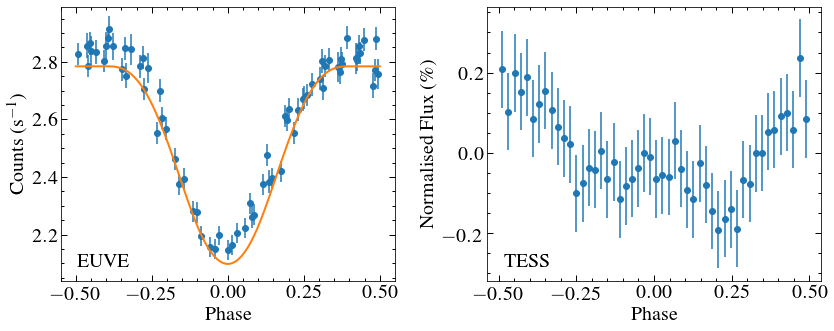

In [46]:
#eph = 2458737.560(0.018)

plt.figure(figsize=(12,5))

plt.subplot(121)
#t0 = euve_lc.time[np.where(ef == np.min(ef))[0][0]]
t0 =50004.27+0.5
efold = euve_lc.fold(1.15, t0 = t0)
plt.errorbar(efold.time, efold.flux, yerr=efold.flux_err, marker='o', ls='none')
plt.plot(phase-0.5, mod, c='C1', lw=2, zorder=10)
plt.xlabel('Phase')
plt.ylabel('Counts (s$^{-1}$)')
plt.annotate('EUVE', (0.05,0.05), xycoords='axes fraction' )
plt.ylim(2.04, 2.99)

plt.subplot(122)
data = fits.getdata('joint_lc.fits', 1)
t, f, e = data['TIME'], data['FLUX'], data['FLUX_ERR']
lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)
print(pbin)
lc_fold2 = lc.fold(1.1468, t0 =2458737.560 ).bin(pbin)
plt.errorbar(lc_fold2.time, lc_fold2.flux*100, yerr=lc_fold2.flux_err*100, marker='o', ls='none')
plt.xlabel('Phase')
plt.ylabel('Normalised Flux (\%)')
plt.annotate('TESS', (0.05,0.05), xycoords='axes fraction' )

plt.tight_layout()
#plt.savefig('plots/euve_v_tess.pdf', dpi=150)

#plt.scatter(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, s=10, c='C1')

Can I get the model to fit the TESS data by tweaking the model opacity? Need the un-normalised TESS data

461.29333


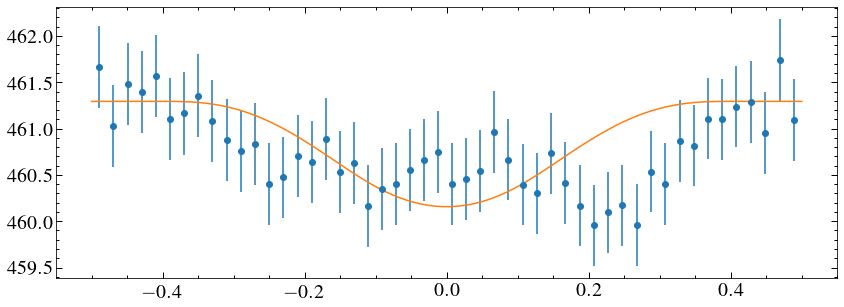

In [47]:
tessfits = glob.glob('tess_fits_files/*fits')
data = fits.getdata(tessfits[0],1)
t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
t, f, e = t[q==0], f[q==0], e[q==0]
lc1 = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)

data = fits.getdata(tessfits[1],1)
t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
t, f, e = t[q==0], f[q==0], e[q==0]
lc2 = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)

lc = lc1.append(lc2)
lcfold = lc.fold(1.1468, t0 =2458737.560 ).bin(pbin)
plt.errorbar(lcfold.time, lcfold.flux, yerr=lcfold.flux_err, marker='o', ls='none')


phi = np.linspace(0, 360, 100)
#ds = [np.tan((1-p)*np.pi) for p in phi]
utess = np.mean(lcfold.flux[lcfold.flux > 461])
print(utess)
gamma = 35.55*np.pi/180
counts = np.array([spot(p*np.pi/180, gamma, U =utess, kw=0.99) for p in phi])
plt.plot((phi/360)-0.5, counts[:,0])

making a fittable spot model

In [48]:
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter

@custom_model
def spot_model(x, gamma=1, U=1, kw=0., beta=0, i = np.pi/2, lam=np.pi):
    #phi = np.linspace(0, 360, 100)
    y = np.array([counts_at_phi(p*2*np.pi, gamma, U, kw, beta, i, lam) for p in x+0.5])
    return y
    

def counts_at_phi(phi, gamma, U, kw, beta, i, lam):
    z0 = get_z0(phi, beta, i, lam)
    eps0, reg, d = coverage(phi, gamma, z0) 
    c = U*(1-(1-kw)*eps0)
    return c

def coverage(phi, gamma, z0):
    k = np.sin(gamma)
    d = ((1-k**2)*(1-z0**2))**0.5 
    if  d <= (1 - k**2) and gamma >=np.pi/2:
        eps = 1.0
        reg= 1
    elif  d <= (1 - k**2):
        reg= 2
        eps = (k**2)*z0
    elif  d > (1 - k**2):
        reg= 3
        s = (1 - k**2)/d 
        v = (d - s) / (k*z0)
        eps = (1/np.pi) *( np.arccos(s) - (s*(1-s**2)**0.5) + ( (k**2) * z0*(np.arccos(v) - (v*(1-v**2)**0.5))))
        
    if eps < 0:
        eps = 0 #hack? I guess? It fixes it?
        
    return eps, reg, d

def get_z0(phi, beta, i, lam):
    z0 = np.cos(lam - phi) * np.cos(beta) * np.sin(i) + np.sin(beta) * np.cos(i)
    return z0

In [49]:
def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    '''
    http://learn.astropy.org/rst-tutorials/User-Defined-Model.html
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)

[0.36398206 0.00037059]
0.997505803382184
89.99682632790099
Model: spot_model
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          gamma                U          ...         i                 lam       
    ------------------ ------------------ ... ------------------ -----------------
    1.5707409357673903 461.33026123046875 ... 1.5707963267948966 3.141592653589793
0.990345218363949
[0.00111123]
0.5315361850281242
1.0745106156012634


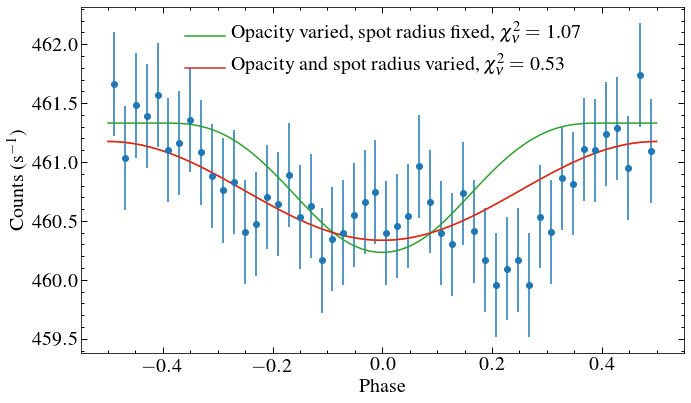

In [50]:
#from scipy.stats import chisquare

plt.figure(figsize=(10,6))
utess = np.mean([np.mean(lcfold.flux[:5]), np.mean(lcfold.flux[-6:])])
dgamma = 35.55*np.pi/180
dbeta = 43.193*np.pi/180 
m_init = spot_model(gamma=dgamma, U=utess, kw = 0.9, beta=dbeta, fixed=dict(gamma=False, U=True, beta=True, i=True, lam=True))#, bounds = dict(kw=[0.7, 0.9999]))
fit = LevMarLSQFitter()
m = fit(m_init, lcfold.time,lcfold.flux, weights=1/lcfold.flux_err, maxiter=100000)
fit_e = np.sqrt(np.diag(fit.fit_info['param_cov']))
print(fit_e)
print(m.kw.value)
#print(m.beta*180/np.pi)
print(m.gamma*180/np.pi)
#print(m.i*180/np.pi)
print(m)
plt.errorbar(lcfold.time, lcfold.flux, yerr=lcfold.flux_err, marker='o', ls='none')
timefit = np.linspace(-0.5,  0.5, 100)
plt.plot(timefit, m(timefit))

m_init2 = spot_model(gamma=dgamma, U=utess, kw = 0.9, beta=dbeta, fixed=dict(gamma=True, U=True, beta=True, i=True, lam=True))#, bounds = dict(kw=[0.7, 0.9999]))
m2 = fit(m_init2, lcfold.time,lcfold.flux, weights=1/lcfold.flux_err, maxiter=100000)
fit_e2 = np.sqrt(np.diag(fit.fit_info['param_cov']))
print(m2.kw.value)
print(fit_e2)

#chi_square1 = np.sum(((lcfold.flux-m(lcfold.time))**2)/lcfold.flux_err**2)/(len(lcfold.time)-2)
#chi_square = np.sum((lcfold.flux-m(lcfold.time))**2)
chi_square1 = calc_reduced_chi_square(m(lcfold.time), lcfold.time , lcfold.flux, lcfold.flux_err, len(lcfold.time), 2)
print(chi_square1)

chi_square2 = calc_reduced_chi_square(m2(lcfold.time), lcfold.time , lcfold.flux, lcfold.flux_err, len(lcfold.time), 1)
#chi_square2 = np.sum(((lcfold.flux-m2(lcfold.time))**2)/lcfold.flux_err**2)/(len(lcfold.time)-1)
#chi_square = np.sum((lcfold.flux-m(lcfold.time))**2)
print(chi_square2)


#print(chisquare(lcfold.flux, m(lcfold.time), ddof=2))

plt.plot(timefit, m2(timefit), label = r'Opacity varied, spot radius fixed, $\chi^{{2}}_{{\nu}}=${0:10.2f}'.format(chi_square2))
plt.plot(timefit, m(timefit), label = r'Opacity and spot radius varied, $\chi^{{2}}_{{\nu}}=${0:10.2f}'.format(chi_square1))
plt.legend()
plt.xlabel('Phase')
plt.ylabel('Counts (s$^{-1}$)')
plt.tight_layout()
plt.savefig('tess_model_fits.pdf')
#plt.plot(lcfold.time, m(lcfold.time-0.5))
#plt.plot(timefit, m_init(timefit))

In [51]:
print(np.mean(lcfold.flux/m2(lcfold.time)))
print(np.mean(lcfold.flux/m(lcfold.time)))

0.9995938280558739
1.0000061405393805


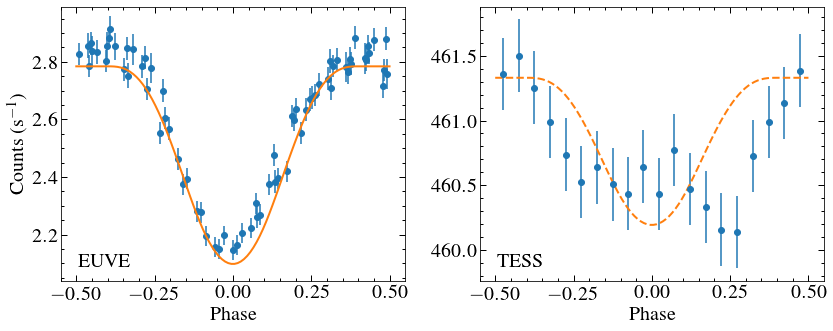

In [52]:
plt.figure(figsize=(12,5))

plt.subplot(121)
#t0 = euve_lc.time[np.where(ef == np.min(ef))[0][0]]
t0 =50004.27+0.5
efold = euve_lc.fold(1.15, t0 = t0)
plt.errorbar(efold.time, efold.flux, yerr=efold.flux_err, marker='o', ls='none')
plt.plot(phase-0.5, mod, c='C1', lw=2, zorder=10)
plt.xlabel('Phase')
plt.ylabel('Counts (s$^{-1}$)')
plt.annotate('EUVE', (0.05,0.05), xycoords='axes fraction' )
plt.ylim(2.04, 2.99)

pbin =int(len(lc_fold.time)/20)
lcfold = lc.fold(1.1468, t0 =2458737.560 ).bin(pbin)
m99 = spot_model(gamma=dgamma, U=utess, kw = 0.99, beta=dbeta) #nominal k=0.99 model


plt.subplot(122)
plt.errorbar(lcfold.time, lcfold.flux, yerr=lcfold.flux_err, marker='o', ls='none')
timefit = np.linspace(-0.5,  0.5, 100)
#plt.plot(timefit, m(timefit))
plt.plot(timefit, m99(timefit), ls='--', lw=2)

plt.xlabel('Phase')
#plt.ylabel('Normalised Flux (\%)')
plt.annotate('TESS', (0.05,0.05), xycoords='axes fraction' )

plt.tight_layout()
#plt.show()
#plt.scatter(lcfold.time, lcfold.flux/m(lcfold.flux))
plt.savefig('plots/euve_v_tess_mod.pdf', dpi=150)

In [53]:
#print(chisquare(efold.flux, interpolate.interp1d(phase-0.5,mod)(efold.time)))
#chi_square = np.sum(((efold.flux-interpolate.interp1d(phase-0.5,mod)(efold.time))/efold.flux_err)**2)/(len(efold.time)-2)
#print(chi_square)

In [54]:
fit.fit_info

{'nfev': 5,
 'fvec': array([-0.75543305,  0.67255548, -0.34021003, -0.14212061, -0.53586079,
         0.51152758,  0.370849  , -0.08445724,  0.49736894,  0.89029509,
         1.0746447 ,  0.79644011,  1.63020501,  1.3014036 ,  0.58290436,
         0.51833002, -0.26204211,  0.32290875, -0.1182186 ,  0.72705213,
         0.1337288 , -0.13520186, -0.5870366 , -0.91890384, -1.15107144,
        -0.37103183, -0.4658504 , -0.59475956, -1.44339427, -0.61937273,
         0.17068949,  0.59388172, -0.16990333,  0.79060667,  1.56830254,
         2.2651107 ,  2.13871614,  2.13970316,  2.77168296,  1.57718277,
         1.96723442,  0.98868716,  1.1376575 ,  0.50108697,  0.5268156 ,
         0.2136032 ,  0.10364664,  0.86308829, -0.9244696 ,  0.54233453]),
 'fjac': array([[-9.32828412e+02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  2.03549531e-05,
          6.36779275e-04,  2.77319040e-03,  7.04599309e-03,
          1.39416580e-02,  2.37522924e-02,  3.67394201e-02,


In [56]:
a = np.array([16, 18, 16, 14, 12, 12], dtype=float) 
b=np.array([16, 16, 16, 16, 16, 8], dtype=float)
print(np.sum(((a-b)**2)/b))
#chisquare(a,b)

3.5


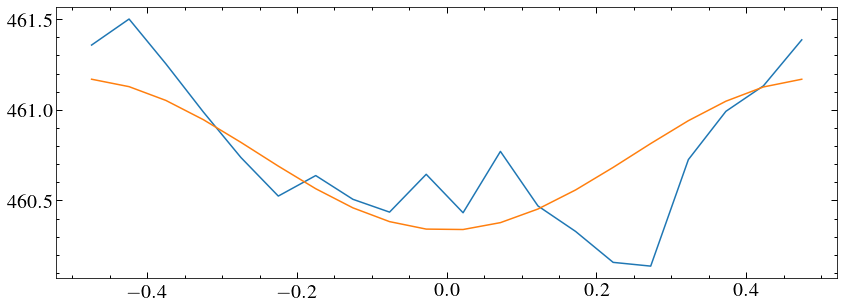

In [57]:
plt.plot(lcfold.time, lcfold.flux)
plt.plot(lcfold.time, m(lcfold.time))

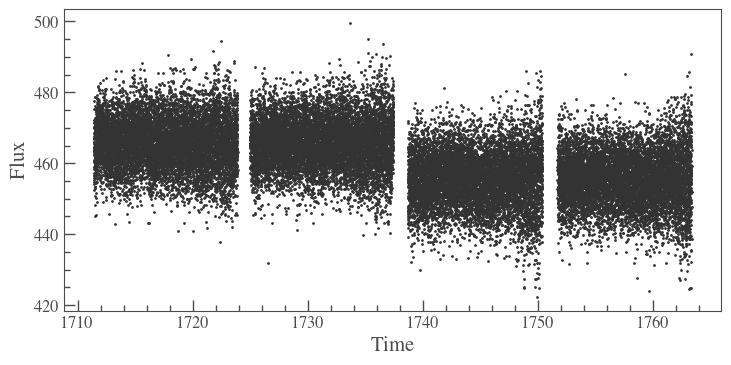

In [58]:
lc.scatter()

STIS lightcurve - just intergrate the flux on each spectrum? Check what I did a few months ago

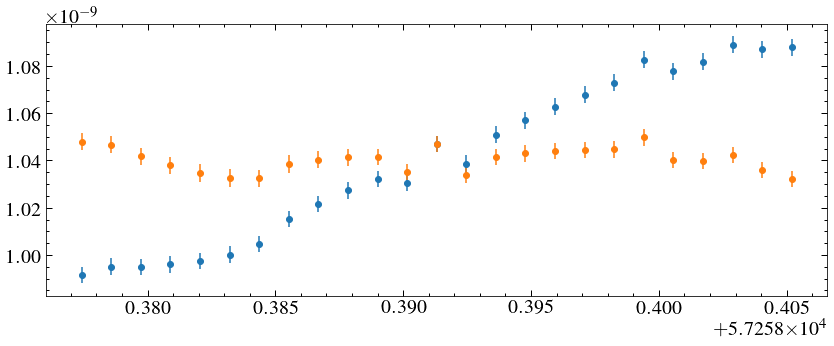

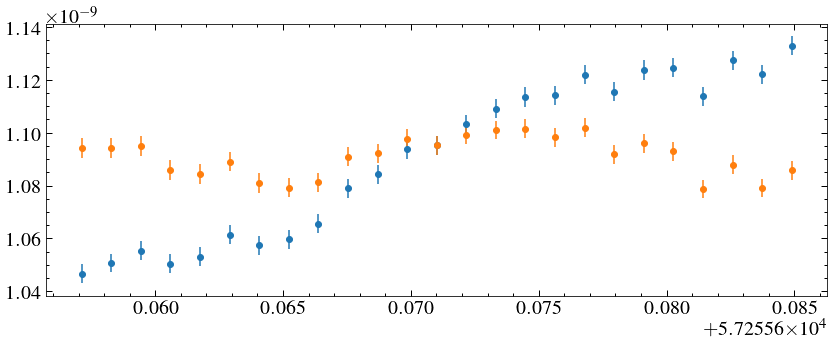

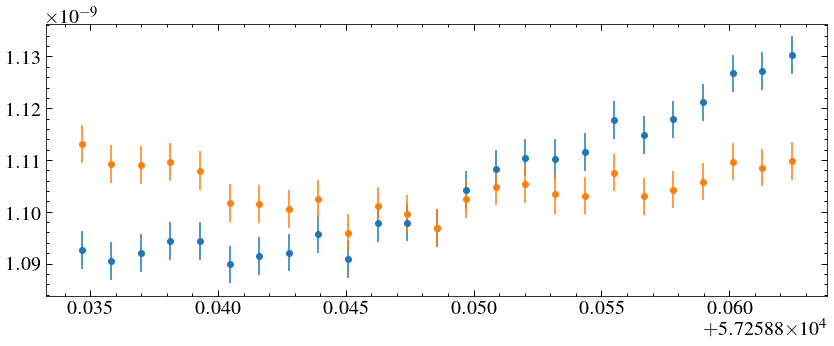

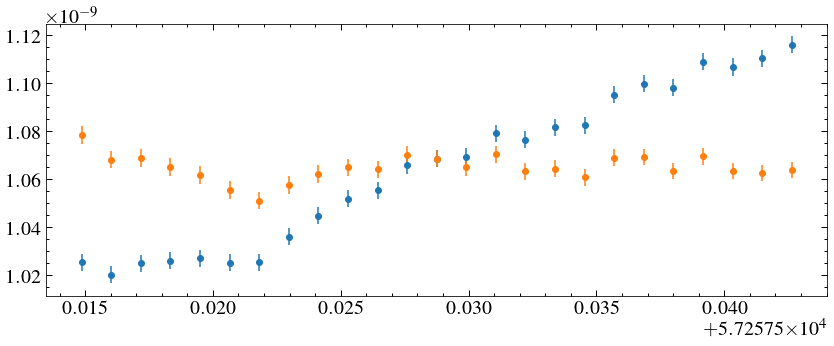

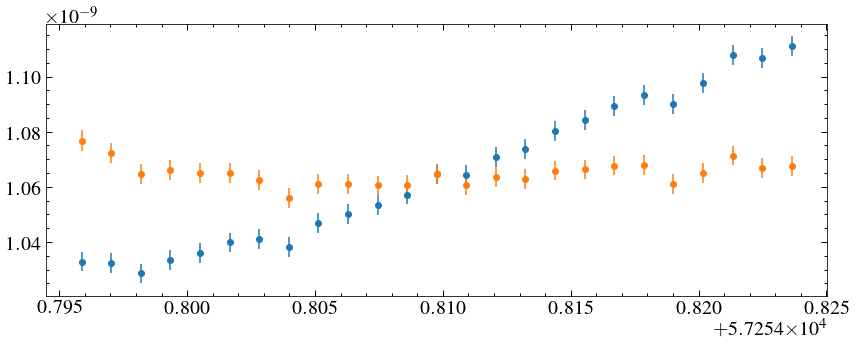

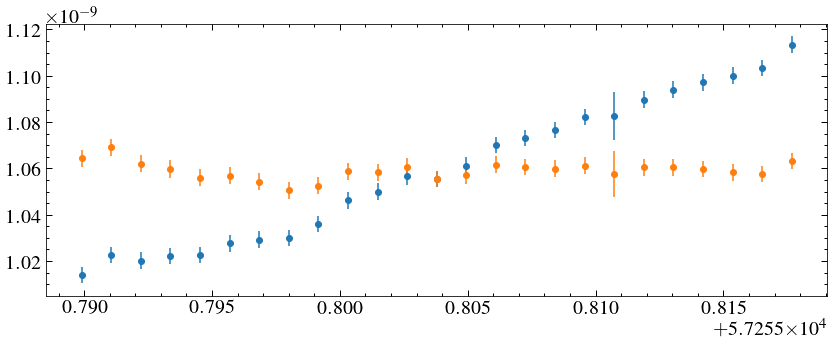

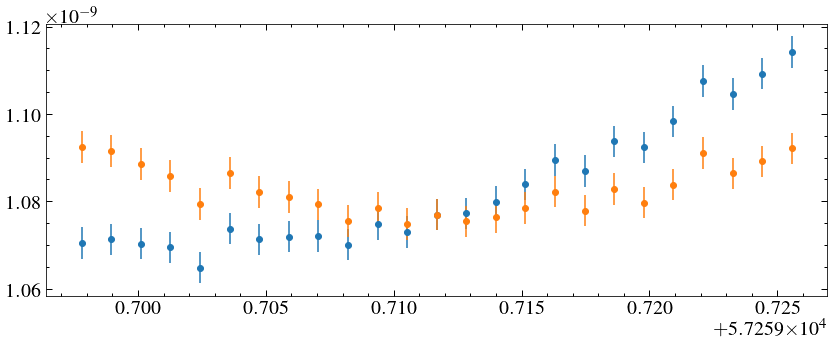

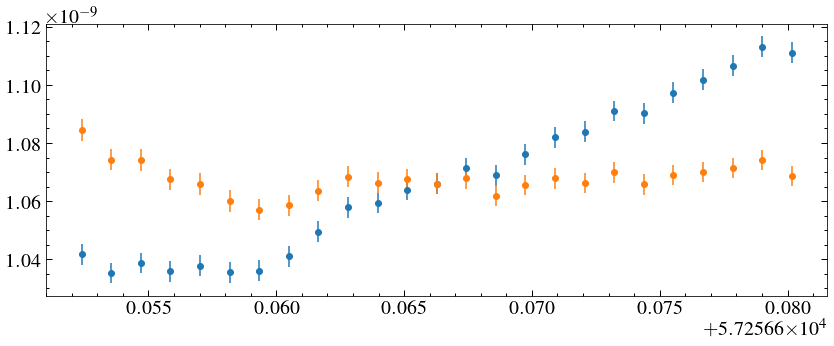

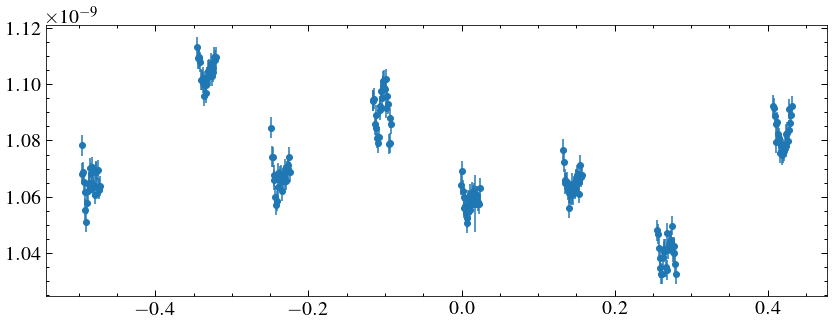

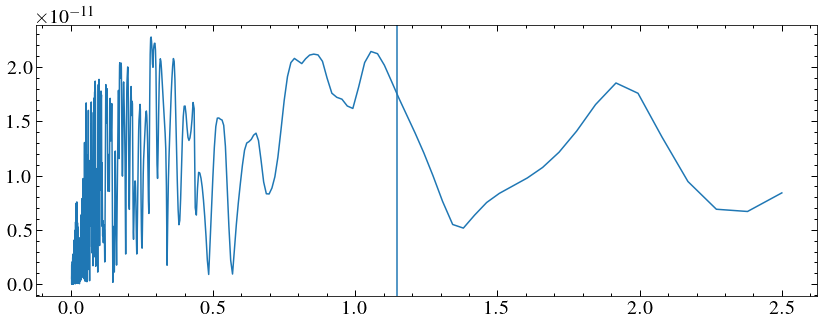

In [86]:
stis_lcs = glob.glob('../inttag/*100s_lc.ecsv')
stime, sflux, serror = np.array([], dtype=float), np.array([], dtype=float), np.array([], dtype=float)
for i, lcpath in enumerate(stis_lcs):
    data = Table.read(lcpath)
    t, f, e = data['TIME'], data['FLUX'], data['ERROR']
    plt.errorbar(t, f, yerr=e, marker='o', ls='none' )
    fm = np.mean(f)
    f /=fm
    fit = np.polyval((np.polyfit(t,f,1)), t)
    f /= fit
    f *=fm
    e /= fit
    plt.errorbar(t, f, yerr=e, marker='o', ls='none' )
    plt.show()
    stime = np.concatenate((stime, t))
    sflux = np.concatenate((sflux, f))
    serror = np.concatenate((serror, e))
args = np.argsort(stime)
stime, sflux, serror = stime[args], sflux[args], serror[args]
lc_stis = lk.LightCurve(time=stime, flux=sflux, flux_err=serror)
#plt.errorbar(stime, sflux, yerr=serror, marker='o', ls='none' )
lcs_fold = lc_stis.fold(1.1468, t0 =2458737.560 )
plt.errorbar(lcs_fold.time, lcs_fold.flux, yerr=lcs_fold.flux_err, marker='o', ls='none' )
plt.show()
pgs= lc_stis.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
plt.plot(pgs.period, pgs.power)
plt.axvline(1.1468)

Just using the integrated flux from each spectrum

<ErrorbarContainer object of 3 artists>

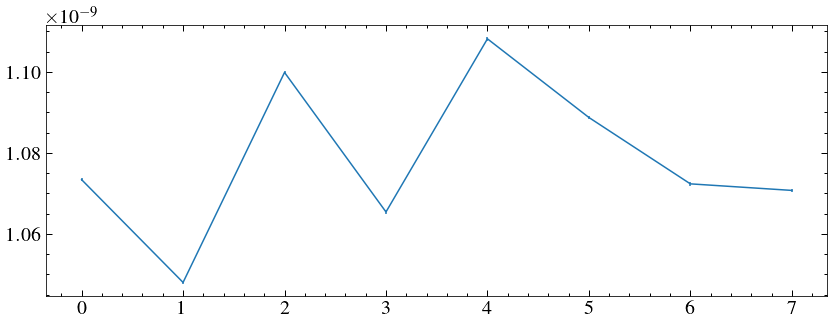

In [101]:
specs = glob.glob('../observations/201808_spectra/stitched_spectra/*.dat')
fs = []
es = []
for spec in specs:
    w, f, e, dq = np.loadtxt(spec, unpack=True)
    mask = (dq==0) & (w > 1160)
    w, f, e = w[mask], f[mask], e[mask]
    #plt.plot(w, f)
    fs.append(np.sum(f[1:]*np.diff(w)))
    es.append(np.sum(f[1:]*np.diff(w))*(np.sum(e**2)**0.5/np.sum(f)))
   # plt.xlim(1200, 1230)

plt.errorbar(np.arange(len(fs)), fs, yerr=es)

In [113]:
def spectra_adder(f_array, e_array):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return flux, error

def echelle_coadd(wavelength, flux, err, nclip =5):
    """
    combines echelle orders into one spectrum, stiching them together at the overlap 
    """
    #slice dodgy ends off orders (usually 5-10 for stis el40m)
    wavelength = wavelength[:, nclip:-(nclip+1)]
    flux = flux[:, nclip:-(nclip+1)]
    err = err[:, nclip:-(nclip+1)]
    
    #new arrays to put the output in
    w_full = np.array([], dtype=float)
    f_full = np.array([], dtype=float)
    e_full = np.array([], dtype=float)   

    shape = np.shape(flux)
    order = 0
    while order < (shape[0]):
        
        #first add the part that does not overlap ajacent orders to the final spectrum
        if order == 0: #first and last orders do not overlap at both ends
            overmask = (wavelength[order] > wavelength[order + 1][-1])
        elif order == shape[0]-1:
            overmask = (wavelength[order] < wavelength[order - 1][1])
        else:
            overmask = (wavelength[order] > wavelength[order + 1][-1]) & (wavelength[order] < wavelength[order - 1][1])
        w_full = np.concatenate((w_full, wavelength[order][overmask]))
        f_full = np.concatenate((f_full, flux[order][overmask]))
        e_full = np.concatenate((e_full, err[order][overmask]))
  
        if order != shape[0]-1:
            
            #interpolate each order onto the one beneath it, with larger wavelength bins. Code adapted from stisblazefix
            f = interpolate.interp1d(wavelength[order + 1], flux[order + 1], fill_value='extrapolate')
            g = interpolate.interp1d(wavelength[order + 1], err[order + 1], fill_value='extrapolate')
            overlap = np.where(wavelength[order] <= wavelength[order + 1][-1])
            f0 = flux[order][overlap]
            f1 = f(wavelength[order][overlap])
            g0 = err[order][overlap]
            g1 = g(wavelength[order][overlap])
       
             
            #combine flux and error at overlap and add to final spectrum
            w_av = wavelength[order][overlap]
            f_av, e_av = spectra_adder(np.array([f0,f1]),np.array([g0,g1]))
            w_full = np.concatenate((w_full, w_av))
            f_full = np.concatenate((f_full, f_av))
            e_full = np.concatenate((e_full, e_av))
        order += 1
    
    #stis orders are saved in reverse order, so combined spectra are sorted by the wavelength array
    arr1inds = w_full.argsort()
    sorted_w = w_full[arr1inds]
    sorted_f = f_full[arr1inds]
    sorted_e = e_full[arr1inds]
 
    
    return sorted_w, sorted_f, sorted_e

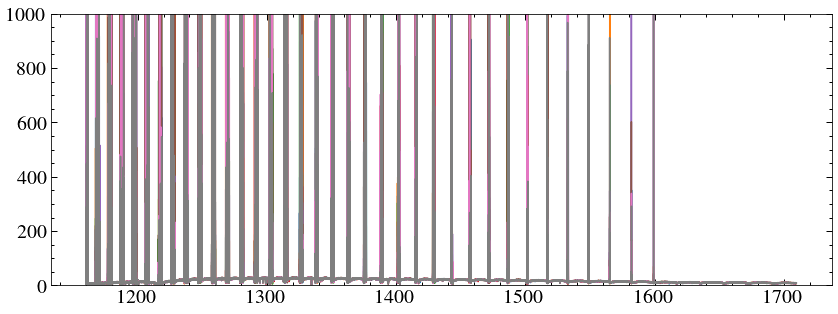

In [119]:
x1ds = glob.glob('../observations/201808_spectra/*.fits')
for x1d in x1ds:
    hdul = fits.open(x1d)
    t = (hdul[0].header['TEXPSTRT'] + hdul[0].header['TEXPEND'])/2
    ext = hdul[1]
    data = ext.data
    hdr = ext.header
    w, f, e, = echelle_coadd(data['WAVELENGTH'], data['FLUX'], data['ERROR'])
    mask = (w> 1160)
    plt.plot(w[mask],f[mask]/e[mask])
    plt.ylim(0, 1000)

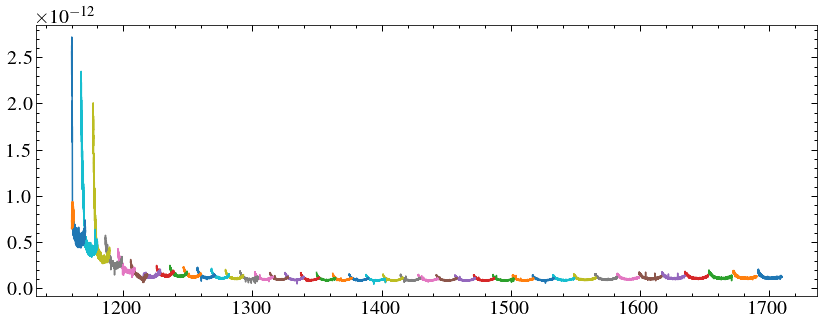

In [123]:
for x1d in x1ds[:1]:
    data = fits.getdata(x1d, 1)
    for dt in data:
        mask = dt['WAVELENGTH'] > 1160
        #plt.plot(dt['WAVELENGTH'][mask][5:-6], dt['FLUX'][mask][5:-6])
        plt.plot(dt['WAVELENGTH'][mask][5:-6], dt['ERROR'][mask][5:-6])
 

In [112]:
data['WAVELENGTH'][:,5:-5]

array([[1691.1666896 , 1691.18510854, 1691.2035271 , ..., 1709.60200676,
        1709.62006059, 1709.63811406],
       [1671.93152795, 1671.9497355 , 1671.96794268, ..., 1690.15534562,
        1690.1731924 , 1690.19103883],
       [1653.12886654, 1653.14686737, 1653.16486783, ..., 1671.14585518,
        1671.16349949, 1671.18114345],
       ...,
       [1158.13131727, 1158.14384579, 1158.15637406, ..., 1170.67345977,
        1170.68574475, 1170.69802951],
       [1149.07563967, 1149.08806755, 1149.10049518, ..., 1161.51709798,
        1161.52928442, 1161.54147062],
       [1140.16041876, 1140.17274755, 1140.18507608, ..., 1152.50273672,
        1152.51482611, 1152.52691527]])